# Comparison in methods with gradient in the channel and without

The purpose of this notebook is to compare the approaches presented in papers *An Introduction to Deep Learning for the Physical Layer* by [O'Shea and Hoydis, 2017](https://arxiv.org/pdf/1702.00832.pdf) and *End-to-End Learning of Communications Systems Without a Channel Model* by [Aoudia and Hoydis, 2018](https://arxiv.org/pdf/1804.02276.pdf). Both approaches propose Deep Neural Networks to learn End-to-end communication systems. The difference between them is that the work by O'Shea and Hoydis relies that we know the gradients of the channel while the one by Aoudia and Hoydis doesn't. Instead Aoudia and Hoydis approach has a feedback from the receiver to the transmitter and uses a policy converting it in a Reinforcement Learning task.

For the implementation of both approaches we are going to use Pytorch. First making all the necessary imports.

In [1]:
import torch
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import math

# To make the plots
import matplotlib.pyplot as plt
%matplotlib inline

# To supress some strange output at runtime
from IPython.utils import io
# Used during plotting the training loss
from IPython import display

If possible we are going to use GPU to train faster

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Pytorch device: %s' % (device))

Pytorch device: cuda:0


The models implemented in Pytorch and other necessary utilities are loaded from different files. This is done to have a single point of modification and the modules can be used in different places. It also helps us to keep this notebook as clean as possible and focus on the results.

In [2]:
from models import Transmitter, Receiver, Policy, Encoder, Decoder
from utils import plot_constellation, count_errors, MemoryMessages, recover_models
from comms_utils import channel, block_encoder, block_decoder, bler

All the pretrained models are located at this folder. Also if we use this notebook to train a new model is going to be saved at this folder

In [3]:
MODELS_FOLDER = 'trained_models'

This is a flag tha indicates if the notebook should train the models. If the flag is `False` then it is assumed we have some pre-trained models

In [5]:
train = True

## Supervised approach. 

This will be the training loop for the first approach defined in *An Introduction to Deep Learning for the Physical Layer*. It is called supervised because it can be reduced to an Autoencoder with a classification task at the end. We know what goes in into the encoder so we just have to *classify* what comes out of the decoder

In [20]:
def train_supervised(m, n, snr_db=10, chann_type="AWGN", batch_size=32, stop_value=0.005,
                     n_epochs=1000, lr=0.001, plot=None):
    # Get k. Number of bits necessary to transmit the m messages
    k = math.log2(m)
    
    # Initialize the encoder and decoder
    encoder = Encoder(m=m, n=n, use_embedding=True, use_paper_norm=False)
    encoder.to(device)
    decoder = Decoder(m=m, n=n)
    decoder.to(device)
    
    # Adam optimizer for both encoder and decoder
    enc_optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
    dec_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)

    # Variables to keep track of losses during training
    losses = []
    avg_losses = []
    errors = []
    avg_errors = []

    for epoch in range(n_epochs):
        epoch_errors = 0
        # Beginning of the epoch. Fill out the memory
        messages = MemoryMessages(m)

        # Until we have something in the memory the epoch has not finished
        while len(messages) > 0:
            # Sample from the memory that is left
            batch, _ = messages.sample(batch_size)
            batch_len = len(batch)

            # Make sure the gradients are zero
            enc_optimizer.zero_grad()
            dec_optimizer.zero_grad()

            # If we are using embedding the input must be an integer with the id of the message to transmit
            # e.g. [0, 1, 2, 3, ...]
            data = torch.from_numpy(batch).unsqueeze(1).to(device)

            # Encode the data
            encoded_data = encoder(data)

            # Pass the encoded message through the channel
            data_channel = channel(encoded_data, n, k, snr_db, chann_type=chann_type)

            # Decode the message
            decoded_data = decoder(data_channel)

            # Check if the received labels are the same as the originals
            targets = torch.from_numpy(batch).to(device)
            loss = F.nll_loss(decoded_data, targets)

            loss.backward()

            # Get how many classifications mistakes we made
            epoch_errors += count_errors(decoded_data, targets)

            enc_optimizer.step()
            dec_optimizer.step()
            
            losses.append(loss.detach().to("cpu").numpy())
            errors.append(epoch_errors/m)
            
            last_losses = np.array(losses[-100:])
            # If the loss is small enough
            if np.all(last_losses < stop_value):
                return encoder, decoder, errors

        # If we desire to visualize the training we enter this if
        if plot is not None:
            print("Finished epoch: %d. Errors %f. Loss: %f" % (epoch, errors[-1], losses[-1]), end="\r")
            
            if epoch > plot:
                avg = np.mean(losses[-plot:])
                avg_err = np.mean(errors[-plot:])
            else:
                avg = np.mean(losses)
                avg_err = np.mean(errors)
            avg_losses.append(avg)
            avg_errors.append(avg_err)
        
            # Make a plot of training
            if epoch%plot==0 and epoch != 0:
                plt.clf()
    #             plt.plot(losses, label="Loss")
    #             plt.plot(avg_losses, label="Average loss")
                plt.plot(errors, label="Errors. Supervised training")
                plt.plot(avg_errors, label="Average Errors. Supervised training")
                plt.legend(loc='upper right')
                display.clear_output(wait=True)
                display.display(plt.gcf())
            
            if epoch == n_epochs-1:
                print()
                print("Finished training. Errors %f. Loss: %f" % (errors[-1], losses[-1]))
    
    return encoder, decoder, errors

## Alternated approach

Next we are going to define the training loop for the approach in *End-to-End Learning of Communications Systems Without a Channel Model*. The training loop can be divided in 2 major phases:

- Training of the receiver: Can be seen as a supervised learning task
- Training of the transmitter: RL-based training based on an estimated gradient of the loss

This is why from where on forward we are going to refer to this approach as **Alternated**

In [21]:
def train_alternated(m=256, n=4, snr_db=10, sigma_var=0.02, chann_type="AWGN",
                    n_epochs=1000, lr=0.001, batch_size=32, plot=False, stop_value=0.005):
    # Get k. Number of bits necessary to transmit the m messages
    k = math.log2(m)
    
    # Initialize the transmitter, receiver and policy
    tx = Transmitter(m=m, n=n)
    tx.to(device)
    rx = Receiver(m=m, n=n)
    rx.to(device)
    policy = Policy(m=m, n=n, sigma_var=sigma_var)
    policy.to(device)
    
    # Adam optimizer for both rx and tx
    tx_optimizer = torch.optim.Adam(tx.parameters(), lr=lr)
    rx_optimizer = torch.optim.Adam(rx.parameters(), lr=lr)

    # Variables to keep track of training
    losses_tx = []
    losses_rx = []
    avg_losses_tx = []
    avg_losses_rx = []
    errors_rx = []
    errors_tx = []
    
    for epoch in range(n_epochs):
        # Beginning of the epoch. Fill out the memory
        messages = MemoryMessages(m)
        error_rx = 0
        error_tx = 0
        
        # Until we have something in the memory the epoch has not finished
        while len(messages) > 0:
            # Sample from the memory that is left
            batch, _ = messages.sample(batch_size)
            batch_len = len(batch)

            # ** Phase 1 of alternated training - Train receiver **
            rx_optimizer.zero_grad()
            
            # To ensure we are not using gradients from the channel
            with torch.no_grad():
                inputs_rx = torch.from_numpy(batch).unsqueeze(1).to(device)

                tx.eval()
                x_encoded = tx(inputs_rx)
                tx.train()

                x_channel = channel(x=x_encoded, n=n, k=k, snr_db=snr_db, chann_type=chann_type)
            
            # Get only gradients from the receiver
            y = rx(x_channel, chann_type=chann_type)
            
            # Classification task. Supervised training. Check if what we received is correct
            targets = torch.from_numpy(batch).to(device)
            loss_rx = F.nll_loss(y, targets)
            loss_rx.backward()

            # Count the errors that we had in this phase
            error_rx += count_errors(y, targets)
            rx_optimizer.step()
        
            # ** Phase 2 of alternated training - Train transmitter **
            tx_optimizer.zero_grad()
            
            inputs_tx = torch.from_numpy(batch).unsqueeze(1).to(device)
            
            # Get gradients from the transmitter and the policy
            x_encoded = tx(inputs_tx)
            xp, xp_logprob = policy(x_encoded)
            
            # To ensure we are not using gradients from the channel
            with torch.no_grad():
                xp_channel = channel(x=xp, n=n, k=k, snr_db=snr_db, chann_type=chann_type)

                rx.eval()
                y = rx(xp_channel, chann_type=chann_type)
                rx.train()
                
                targets = torch.from_numpy(batch).to(device)
                per_example_losses = F.nll_loss(y, targets, reduction='none')
            
            # With the per example losses calculated at the receiver make the loss of the transmitter
            # NB the per example losses do not have a gradient
            loss_tx = torch.mean(per_example_losses.detach().unsqueeze(1)*xp_logprob.reshape(batch_len, 2*n))
            loss_tx.backward()
            
            # Count the errors that we had in this phase
            error_tx += count_errors(y, targets)
            
            tx_optimizer.step()
        
        losses_rx.append(loss_rx.detach().to("cpu").numpy())
        losses_tx.append(loss_tx.detach().to("cpu").numpy())
        errors_rx.append(error_rx/m)
        errors_tx.append(error_tx/m)
        
        # If the loss is small enough
        last_losses = np.array(losses_rx[-100:])
        if np.all(last_losses < stop_value):
            return tx, rx, errors_rx, errors_tx
            
        # If we desire to visualize the training we enter this if
        if plot is not None:
            print("Finished epoch: %d. Error rx: %f. Error tx: %f. Loss rx: %f. Loss tx: %f" % (epoch,
                                                                                                errors_rx[-1], errors_tx[-1],
                                                                                                losses_rx[-1], losses_tx[-1]), end="\r")

            if epoch > plot:
                avg_rx = np.mean(losses_rx[-plot:])
                avg_tx = np.mean(losses_tx[-plot:])
            else:
                avg_rx = np.mean(losses_rx)
                avg_tx = np.mean(losses_tx)
            avg_losses_rx.append(avg_rx)
            avg_losses_tx.append(avg_tx)

            # Make a plot of training
            if epoch%plot==0 and epoch != 0:
                plt.clf()
                plt.plot(errors_rx, label="Rx errors. Alternating training")
                plt.plot(errors_tx, label="Tx errors. Alternating training")
                plt.legend(loc='upper right')
                display.clear_output(wait=True)
                display.display(plt.gcf())
            
            if epoch == n_epochs-1:
                print()
                print("Finished training. Error rx: %f. Error tx: %f. Loss rx: %f. Loss tx: %f" % (errors_rx[-1], errors_tx[-1],
                                                                                                   losses_rx[-1], losses_tx[-1]))


    return tx, rx, errors_rx, errors_tx

First we are going to train and see the results with the parameters proposed in *End-to-End Learning of Communications Systems Without a Channel Model*. $(M, n) = (256, 4)$. In a traditional communications notation it is equivalent to $(n, k) = (4, 8)$. This means that the purpose of the trained system is to use 4 bits to represent messages that would need at least 8 bits to be represented. Normally in communcations we try to do the opposite, use more bits $n > k$

In [8]:
# These are the parameters in the paper End-to-End Learning of Communications Systems Without a Channel Model
# Train both models with them
m = 256
n = 4
snr_db = 10
chann_type = "AWGN"

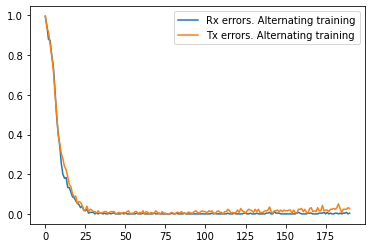

Finished epoch: 199. Error rx: 0.007812. Error tx: 0.019531. Loss rx: 0.054333. Loss tx: -39.6122744
Finished training. Error rx: 0.007812. Error tx: 0.019531. Loss rx: 0.054333. Loss tx: -39.612274
Models saved in trained_models/AWGN_256_4_tx.pth, trained_models/AWGN_256_4_rx.pth


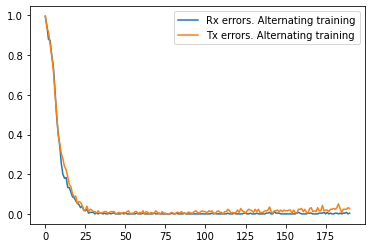

In [9]:
if train:
    # Training loop
    tx, rx, errors_rx, errors_tx = train_alternated(m=m, n=n, snr_db=snr_db, chann_type=chann_type, lr=0.001,
                                                   batch_size=32, n_epochs=200, plot=10)


    # Save the trained models
    tx_filename = "%s/%s_%d_%d_tx.pth" % (MODELS_FOLDER, chann_type, m, n)
    rx_filename = "%s/%s_%d_%d_rx.pth" % (MODELS_FOLDER, chann_type, m, n)
    torch.save(tx.state_dict(), tx_filename)
    torch.save(rx.state_dict(), rx_filename)

    print("Models saved in %s, %s" % (tx_filename, rx_filename))
    
    torch.cuda.empty_cache()

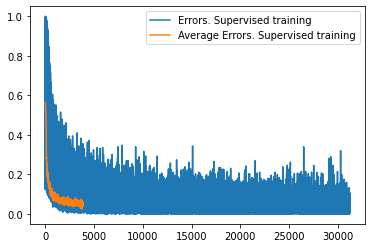

Finished epoch: 3999. Errors 0.046875. Loss: 0.463021
Finished training. Errors 0.046875. Loss: 0.463021
Models saved in trained_models/AWGN_256_4_encoder.pth, trained_models/AWGN_256_4_decoder.pth


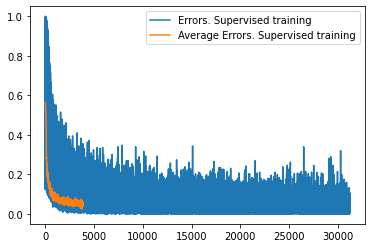

In [10]:
if train:
    # Training loop
    encoder, decoder, errors = train_supervised(m=m, n=n, snr_db=snr_db, chann_type=chann_type, batch_size=32,
                                                n_epochs=4000, lr=0.001, plot=100)

    # Save the trained models
    enc_filename = "%s/%s_%d_%d_encoder.pth" % (MODELS_FOLDER, chann_type, m, n)
    dec_filename = "%s/%s_%d_%d_decoder.pth" % (MODELS_FOLDER, chann_type, m, n)
    torch.save(encoder.state_dict(), enc_filename)
    torch.save(decoder.state_dict(), dec_filename)

    print("Models saved in %s, %s" % (enc_filename, dec_filename))
    
    torch.cuda.empty_cache()

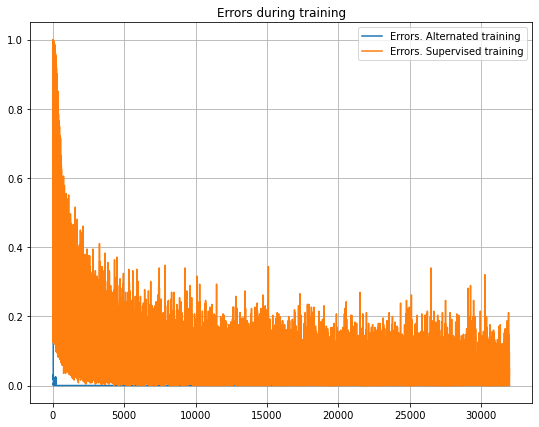

In [11]:
# Compare the errors we had at training with both approaches
if train:
    # Normally we trained supervised approach for more epochs.
    # This lines are to make them the same size
    errors_alternating = (np.array(errors_tx) + np.array(errors_rx))/2
    errors_supervised = errors
    padd_needed = len(errors_supervised) - len(errors_alternating)
    errors_alternating_pad = np.pad(errors_alternating, (0, padd_needed), 'constant', constant_values=0)

    # Plot the errors
    plt.figure(figsize=(9, 7))
    plt.plot(errors_alternating_pad, label="Errors. Alternated training")
    plt.plot(errors_supervised, label="Errors. Supervised training")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.title("Errors during training")
    plt.show()

Now we can watch the constellations generated by our Tx and our Encoder. This is done by getting the encoding for all possible messages and then adding 20 noise samples. So for every $m$ message of $M$ we will plot 20 different samples with noise. After adding the noise we will visualize the constellation using 2 dimensional t-SNE. If the encoder and Tx are trained properly we would be able to clearly distinguish between the groups of noisy samples of each $m$ message.

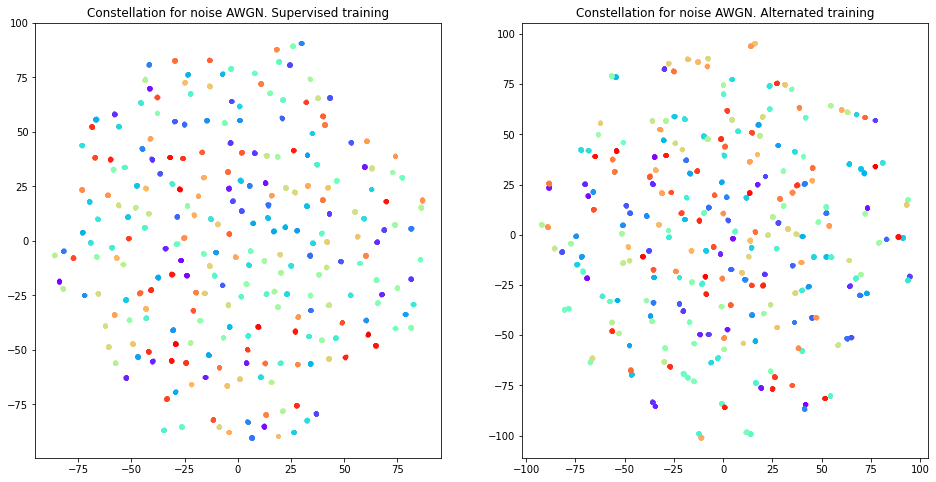

In [12]:
# Observe the constellations that were generated with each approach
# An embedding to 2 dimensions using t-SNE was used to plot this
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), facecolor='w')
ax1 = plot_constellation(m=256, n=4, model="supervised", ax=ax1, device=device)
ax2 = plot_constellation(m=256, n=4, model="alternated", ax=ax2, device=device)

## End-to-end communication

We have now trained for both approaches. The next thing to do is to use the trained models to define the end-to-end communications. We use the pre-trained models to encode a block of messages. First the messages will go through the Tx/Encoder, then they will go through the channel that will add noise and at the end we will pass them through the Rx/Decoder. As mentioned before, the Rx will output the probability the received sample corresponds to each $m$ message. We are going to pick the one with highest probability. After this decission we are going to check how many mistakes we had i.e. calculate the Block Error Rate (BLER).

In [35]:
def nn_communication(m, n, snr_db, n_blocks, chann_type="AWGN", model="supervised", verbose=False):
    enc, dec = recover_models(device, model=model, m=m, n=n, chann_type=chann_type)
    
    # Print the parameters of our trained models
    if verbose: print("Models")
    if verbose: print(enc)
    if verbose: print(dec)
    if verbose: print()

    k = math.log2(m)
    # We are not training hence not using gradients. Just evaluating
    with torch.no_grad():
        # Generate as much data as specified in the parameters
        data = torch.randint(0, m, (n_blocks, 1)).to(device)
        if verbose: print("Original x")
        if verbose: print(data)
        
        # Encode the data (Tx)
        enc_data = enc(data)
        if verbose: print("Encoded x")
        if verbose: print(enc_data)
    
        # Pass the data through the channel. Add noise
        noise_data = channel(enc_data, n, k, snr_db, chann_type=chann_type)
        if verbose: print("x with noise")
        if verbose: print(noise_data)
        
        # Decode the data (Rx)
        dec_data = dec(noise_data, chann_type=chann_type)
        
        # The last layer returns probabilites over all possible messages
        # Choos the one that has the highest one
        data_dec = torch.argmax(dec_data, dim=1).unsqueeze(1)
        if verbose: print("Recovered x")
        if verbose: print(data_dec)
        
        # Count the errors that we had
        errors = data_dec != data
        total_errors = errors.sum().to("cpu").numpy()

    # Get the error. Rate of the errrors
    bler = total_errors/n_blocks
    if verbose: print("BLER")
    if verbose: print(bler)

    print("Finished calculations for channel (%s). SNR dB: %f." % (chann_type, snr_db))
    return bler

In [36]:
# Visualize for the supervised approach
nn_communication(m=256, n=4, snr_db=0, n_blocks=10, model="supervised", chann_type="AWGN", verbose=True)
torch.cuda.empty_cache()

Models
Encoder(
  (linear_M): Sequential(
    (0): Embedding(256, 256)
    (1): ReLU()
  )
  (linear_N): Sequential(
    (0): Linear(in_features=256, out_features=4, bias=True)
  )
  (normalization): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Decoder(
  (linear_relu): Sequential(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): ReLU()
  )
  (linear_out): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): LogSoftmax()
  )
)

Original x
tensor([[153],
        [155],
        [ 49],
        [189],
        [ 43],
        [176],
        [136],
        [208],
        [ 59],
        [ 39]], device='cuda:0')
Encoded x
tensor([[-3.1385, -1.4431,  1.2202, -1.7877],
        [-1.0541, -1.0679,  4.1271,  0.7468],
        [ 0.9141, -1.5453,  3.1390,  0.7368],
        [ 0.0676,  1.9721,  3.2915, -3.2703],
        [-2.7056,  1.4390, -3.4901, -0.8934],
        [-1.0359,  0.4548,  1.5310, -1.7149],
        [-0.1751,

In [37]:
# Visualize for the alternated approach
nn_communication(m=256, n=4, snr_db=0, n_blocks=10, model="alternated", chann_type="AWGN", verbose=True)

Models
Transmitter(
  (transmit): Sequential(
    (0): Embedding(256, 256)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=8, bias=True)
  )
  (normalization): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Receiver(
  (receive): Sequential(
    (0): Linear(in_features=8, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LogSoftmax()
  )
  (estimate_h): Sequential(
    (0): Linear(in_features=8, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=2, bias=True)
  )
)

Original x
tensor([[153],
        [130],
        [ 96],
        [228],
        [165],
        [ 78],
        [124],
        [207],
        [ 41],
        [140]], device='cuda:0')
Encoded x
tensor([[[-1.9814, -1.3131],
         [ 0.0178,  0.7638],
         [-0.8129, -1.5726],
         [-2.4467,  0.9349]],

        [[-1.0848,  0.3690],
         [-2.2450, -0.2794],
         [-1

0.4

## Results

We trained both approaches at the same noise level of $\text{SNR}_{\text{dB}}= 10$. Now we are going to evaluate their performance at different noise levels and observe the results

In [16]:
# Defining all noise levels
snrs_db = np.arange(-4, 12, 1)

# Number of input messages to simulate
n_blocks = 200000

# To store the resutls
results_y = np.zeros((2, len(snrs_db)))

# Iterate over all the noise levels
for snr_n, snr_db in enumerate(snrs_db):
    # Get the bler at each noise level
    bler_supervised = nn_communication(m=256, n=4, snr_db=snr_db, n_blocks=n_blocks, model="supervised", chann_type="AWGN")
    bler_alternated = nn_communication(m=256, n=4, snr_db=snr_db, n_blocks=n_blocks, model="alternated", chann_type="AWGN")
    torch.cuda.empty_cache()
    # Store the results
    results_y[0, snr_n] = bler_supervised
    results_y[1, snr_n] = bler_alternated
    
    torch.cuda.empty_cache()

Finished calculations for channel (AWGN). SNR dB: -4.000000.
Finished calculations for channel (AWGN). SNR dB: -4.000000.
Finished calculations for channel (AWGN). SNR dB: -3.000000.
Finished calculations for channel (AWGN). SNR dB: -3.000000.
Finished calculations for channel (AWGN). SNR dB: -2.000000.
Finished calculations for channel (AWGN). SNR dB: -2.000000.
Finished calculations for channel (AWGN). SNR dB: -1.000000.
Finished calculations for channel (AWGN). SNR dB: -1.000000.
Finished calculations for channel (AWGN). SNR dB: 0.000000.
Finished calculations for channel (AWGN). SNR dB: 0.000000.
Finished calculations for channel (AWGN). SNR dB: 1.000000.
Finished calculations for channel (AWGN). SNR dB: 1.000000.
Finished calculations for channel (AWGN). SNR dB: 2.000000.
Finished calculations for channel (AWGN). SNR dB: 2.000000.
Finished calculations for channel (AWGN). SNR dB: 3.000000.
Finished calculations for channel (AWGN). SNR dB: 3.000000.
Finished calculations for channe

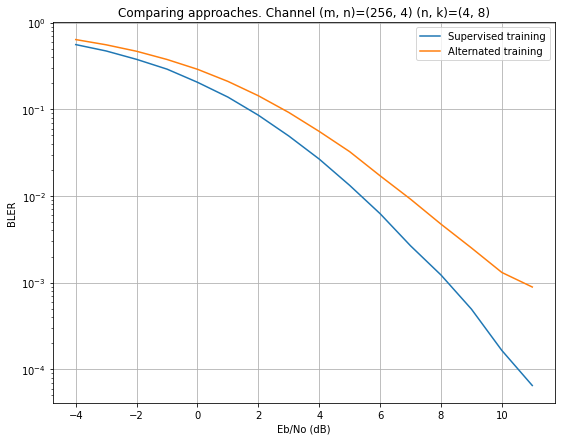

In [17]:
# Plot the results
plt.figure(figsize=(9, 7))
plt.semilogy(snrs_db, results_y[0, :], label="Supervised training")
plt.semilogy(snrs_db, results_y[1, :], label="Alternated training")
plt.legend(loc='upper right')
plt.grid(True)
plt.title("Comparing approaches. Channel (m, n)=(256, 4) (n, k)=(4, 8)")
plt.xlabel('Eb/No (dB)')
plt.ylabel('BLER')
plt.show()

## More results

Last results were obtained using an `M=256` and `n=4`. For representing 256 messages we would need at least 8 bits. This means that we are going to try to go from 8 bits to 4 bits. Normally in communications we do the opposite, we try to use more bits with the purpose of having *redundancy bits* and we can check from errors in the receiver side.

Taking the last into account we are going to now use the proposed encodings in *An Introduction to Deep Learning for the Physical Layer* and compare both approaches with the theoretical results.

In [22]:
# (m, n) representation.
# Equivalent to (n, k) = (4, 4), (7, 4), (8, 8), (2, 2)
hamming_sizes = [(16, 4), (16, 7), (256, 8), (4, 2)]
# Training at a constant SNR
snr_db = 7
chann_type = "AWGN"

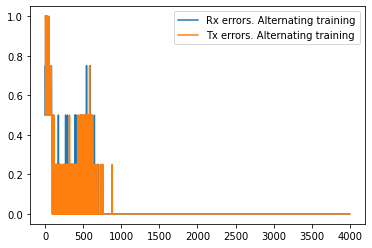

Models saved in trained_models/AWGN_4_2_tx.pth, trained_models/AWGN_4_2_rx.pth5. Loss tx: -0.5505772


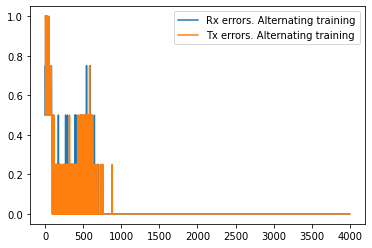

In [23]:
if train:
    for m, n in hamming_sizes:
        print("Training alternated (%d, %d)" % (m, n))
        # Training loop
        tx, rx, errors_rx, errors_tx = train_alternated(m=m, n=n, snr_db=snr_db, chann_type=chann_type, lr=0.001,
                                                       batch_size=32, n_epochs=10000, plot=1000)

        # Save the trained models
        tx_filename = "%s/%s_%d_%d_tx.pth" % (MODELS_FOLDER, chann_type, m, n)
        rx_filename = "%s/%s_%d_%d_rx.pth" % (MODELS_FOLDER, chann_type, m, n)
        torch.save(tx.state_dict(), tx_filename)
        torch.save(rx.state_dict(), rx_filename)

        print("Models saved in %s, %s" % (tx_filename, rx_filename))

Bigger n values seem to converge faster

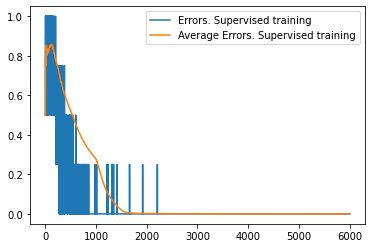

Models saved in trained_models/AWGN_4_2_encoder.pth, trained_models/AWGN_4_2_decoder.pth


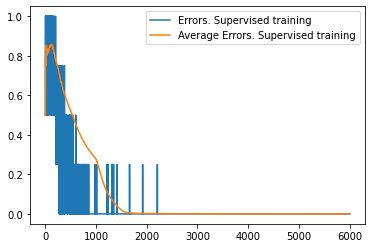

In [24]:
if train:
    for m, n in hamming_sizes:
        print("Training supervised (%d, %d)" % (m, n))
        # Training loop
        encoder, decoder, errors = train_supervised(m=m, n=n, snr_db=snr_db, chann_type=chann_type, batch_size=32,
                                                    n_epochs=10000, lr=0.001, plot=1000)

        # Save the trained models
        enc_filename = "%s/%s_%d_%d_encoder.pth" % (MODELS_FOLDER, chann_type, m, n)
        dec_filename = "%s/%s_%d_%d_decoder.pth" % (MODELS_FOLDER, chann_type, m, n)
        torch.save(encoder.state_dict(), enc_filename)
        torch.save(decoder.state_dict(), dec_filename)

        print("Models saved in %s, %s" % (enc_filename, dec_filename))
        
        torch.cuda.empty_cache()

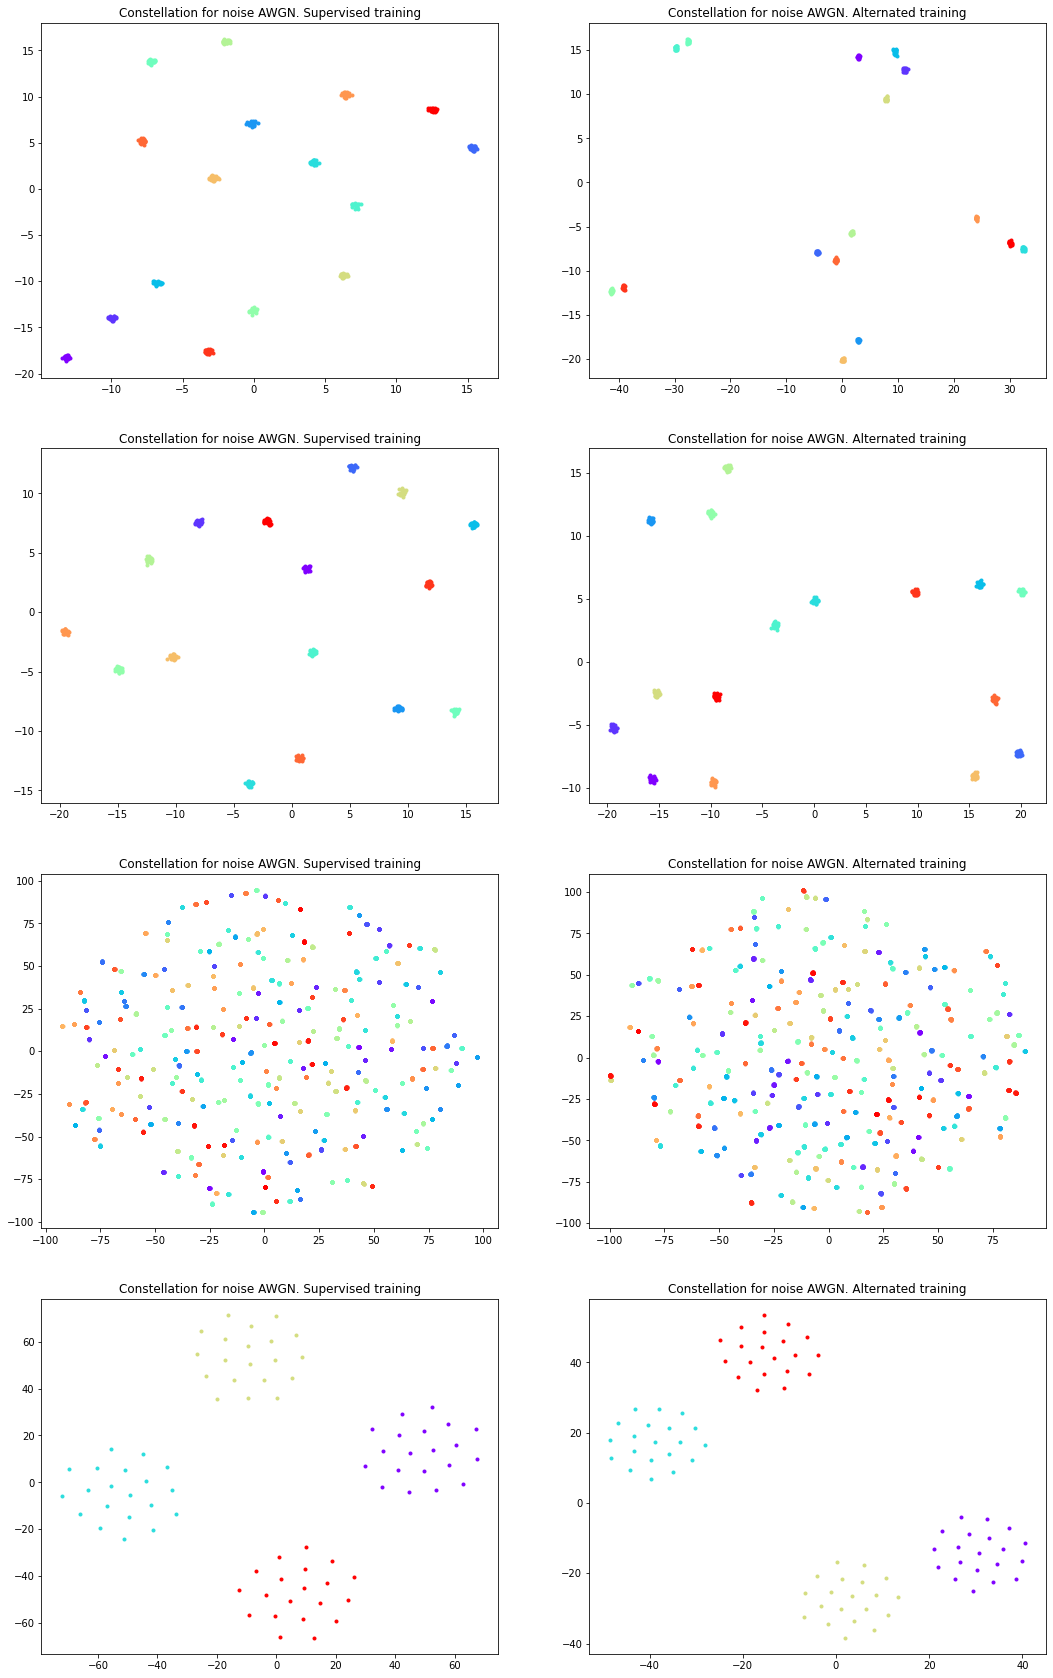

In [25]:
# Observe the constellations that were generated with each approach
# An embedding to 2 dimensions using t-SNE was used to plot this
hamming_sizes = [(16, 4), (16, 7), (256, 8), (4, 2)]
fig, axs = plt.subplots(4, 2, figsize=(18, 30), facecolor='w')
for i, (m, n) in enumerate(hamming_sizes):
    axs[i, 0] = plot_constellation(m=m, n=n, model="supervised", ax=axs[i, 0], device=device)
    axs[i, 1] = plot_constellation(m=m, n=n, model="alternated", ax=axs[i, 1], device=device)

### BPSK communication

We can also simulate BPSK modulation and then compare with the results we obtained. As encoder we would use a Hamming encoder

In [38]:
def bpsk_communication(m, n, snr_db, n_blocks, chann_type=chann_type, verbose=False):
    # Get k. Number of bits necessary to transmit the m messages
    k = int(math.log2(m))

    # Generate inputs
    x = np.random.randint(0, 2, size=(n_blocks, k))
    if verbose: print("Original x")
    if verbose: print(x)
    
    # Encode the messages using Hamming
    # Strange output from library sk_dsp_comm.fec_block when doing hamming coding
    # e.g. (7,4) hamming code object
    # Supressing such output with this line
    with io.capture_output() as captured:
        x_encoded = block_encoder(x, n, k)
    if verbose: print("Encoded x")
    if verbose: print(x_encoded)
    
    # Signal vector to transmit (modulation)
    s_transmit = 2*x_encoded - 1
    if verbose: print("Modulated x")
    if verbose: print(s_transmit)
    
    # Add the noise
    s_noise = channel(s_transmit, n, k, snr_db, chann_type=chann_type)
    if verbose: print("x with noise after channel")
    if verbose: print(s_noise)
    
    # Demoludation of the signal
    y = np.sign(s_noise)
    y_enc = (y + 1)/2
    
    if verbose: print("Demodulated received x")
    if verbose: print(y_enc.astype(int))

    # Decode them using Hamming
    with io.capture_output() as captured:
        x_rec = block_decoder(y_enc.astype(int), n, k)
    
    if verbose: print("Decoded x")
    if verbose: print(x_rec)

    # Get the bler
    block_bler = bler(x, x_rec)
    if verbose: print("BLER")
    if verbose: print(block_bler)
    
    print("Finished calculations for BPSK(%d, %d) channel: %s. SNR dB: %f." % (n, k, chann_type, snr_db))

    return block_bler

In [39]:
# Visualize BPSK communication
bpsk_communication(m=16, n=7, snr_db=0, chann_type="AWGN", n_blocks=10, verbose=True)

Original x
[[0 1 0 1]
 [1 0 0 0]
 [0 0 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [1 1 1 0]
 [1 0 1 0]]
Encoded x
[[0 1 0 1 0 1 1]
 [1 0 0 0 1 1 1]
 [0 0 0 0 0 0 0]
 [0 0 1 0 0 1 1]
 [0 1 0 0 1 1 0]
 [1 0 1 0 1 0 0]
 [0 0 0 1 1 0 1]
 [0 0 0 1 1 0 1]
 [1 1 1 0 0 1 0]
 [1 0 1 0 1 0 0]]
Modulated x
[[-1  1 -1  1 -1  1  1]
 [ 1 -1 -1 -1  1  1  1]
 [-1 -1 -1 -1 -1 -1 -1]
 [-1 -1  1 -1 -1  1  1]
 [-1  1 -1 -1  1  1 -1]
 [ 1 -1  1 -1  1 -1 -1]
 [-1 -1 -1  1  1 -1  1]
 [-1 -1 -1  1  1 -1  1]
 [ 1  1  1 -1 -1  1 -1]
 [ 1 -1  1 -1  1 -1 -1]]
x with noise after channel
[[-8.14134404e-01  1.84995920e+00 -1.34902378e+00  6.71316228e-01
  -7.26406915e-01  2.05747450e-02  2.29388798e+00]
 [ 7.94546866e-01 -1.20709123e+00 -1.14982768e+00 -7.13905190e-01
   1.21538198e+00  1.94769931e+00  1.89578371e+00]
 [-5.35557069e-01 -6.73369245e-01 -1.00612485e+00 -1.59284200e+00
  -6.42535284e-01 -1.61166361e+00 -1.10165551e+00]
 [-2.37519342e-01 -1.26340094e+00  5.22430666e-01 -3.02752728e-01


0.0

As before watching the performance of the systems at different noise levels

In [32]:
# Defining the hamming encoding sizes (m, n)
hamming_sizes = [(16, 4), (16, 7), (256, 8), (4, 2)]

# Defining all noise levels
snrs_db = np.arange(-4, 10, 1)

# Number of input messages to simulate
n_blocks = 300000

# To store the resutls
results_y = np.zeros((3, len(hamming_sizes), len(snrs_db)))

# Iterate over all the (m, n) encodings
for hamm_n, (m, n) in enumerate(hamming_sizes):
    # Iterate over all the noise levels
    for snr_n, snr_db in enumerate(snrs_db):
        # Get the bler at each noise level
        bler_supervised = nn_communication(m=m, n=n, snr_db=snr_db, n_blocks=n_blocks, model="supervised", chann_type="AWGN")
        bler_alternated = nn_communication(m=m, n=n, snr_db=snr_db, n_blocks=n_blocks, model="alternated", chann_type="AWGN")
        bler_bpsk = bpsk_communication(m=m, n=n, snr_db=snr_db, n_blocks=n_blocks, chann_type="AWGN")

        # Store the results
        results_y[0, hamm_n, snr_n] = bler_supervised
        results_y[1, hamm_n, snr_n] = bler_alternated
        results_y[2, hamm_n, snr_n] = bler_bpsk
        
        torch.cuda.empty_cache()

Finished calculations for channel (AWGN). SNR dB: -4.000000.
Finished calculations for channel (AWGN). SNR dB: -4.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: -4.000000.
Finished calculations for channel (AWGN). SNR dB: -3.000000.
Finished calculations for channel (AWGN). SNR dB: -3.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: -3.000000.
Finished calculations for channel (AWGN). SNR dB: -2.000000.
Finished calculations for channel (AWGN). SNR dB: -2.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: -2.000000.
Finished calculations for channel (AWGN). SNR dB: -1.000000.
Finished calculations for channel (AWGN). SNR dB: -1.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: -1.000000.
Finished calculations for channel (AWGN). SNR dB: 0.000000.
Finished calculations for channel (AWGN). SNR dB: 0.000000.
Finished calculations for BPSK(4, 4) channel: AWGN. SNR dB: 0.000000.
Finished calculations for channel (AWG

Finished calculations for BPSK(2, 2) channel: AWGN. SNR dB: -2.000000.
Finished calculations for channel (AWGN). SNR dB: -1.000000.
Finished calculations for channel (AWGN). SNR dB: -1.000000.
Finished calculations for BPSK(2, 2) channel: AWGN. SNR dB: -1.000000.
Finished calculations for channel (AWGN). SNR dB: 0.000000.
Finished calculations for channel (AWGN). SNR dB: 0.000000.
Finished calculations for BPSK(2, 2) channel: AWGN. SNR dB: 0.000000.
Finished calculations for channel (AWGN). SNR dB: 1.000000.
Finished calculations for channel (AWGN). SNR dB: 1.000000.
Finished calculations for BPSK(2, 2) channel: AWGN. SNR dB: 1.000000.
Finished calculations for channel (AWGN). SNR dB: 2.000000.
Finished calculations for channel (AWGN). SNR dB: 2.000000.
Finished calculations for BPSK(2, 2) channel: AWGN. SNR dB: 2.000000.
Finished calculations for channel (AWGN). SNR dB: 3.000000.
Finished calculations for channel (AWGN). SNR dB: 3.000000.
Finished calculations for BPSK(2, 2) channel: 

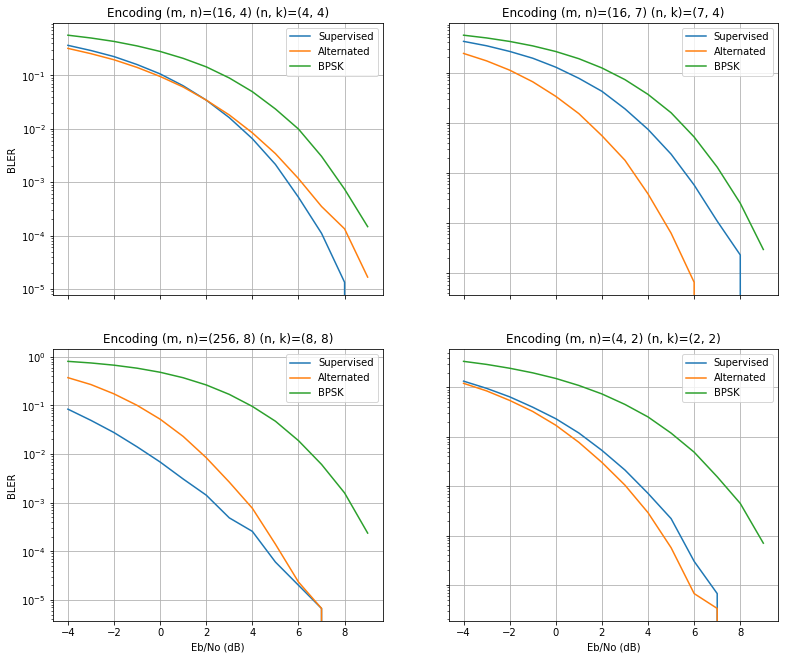

In [33]:
# Comparing each autoencoder with the theoritcal result
fig, axs = plt.subplots(2, 2, figsize=(13, 11), facecolor='w')

axs[0, 0].semilogy(snrs_db, results_y[0, 0,:], label='Supervised')
axs[0, 0].semilogy(snrs_db, results_y[1, 0,:], label='Alternated')
axs[0, 0].semilogy(snrs_db, results_y[2, 0,:], label='BPSK')
axs[0, 0].legend(loc='upper right')
axs[0, 0].set_title('Encoding (m, n)=(16, 4) (n, k)=(4, 4)')

axs[0, 1].semilogy(snrs_db, results_y[0, 1,:], label='Supervised')
axs[0, 1].semilogy(snrs_db, results_y[1, 1,:], label='Alternated')
axs[0, 1].semilogy(snrs_db, results_y[2, 1,:], label='BPSK')
axs[0, 1].legend(loc='upper right')
axs[0, 1].set_title('Encoding (m, n)=(16, 7) (n, k)=(7, 4)')

axs[1, 0].semilogy(snrs_db, results_y[0, 2,:], label='Supervised')
axs[1, 0].semilogy(snrs_db, results_y[1, 2,:], label='Alternated')
axs[1, 0].semilogy(snrs_db, results_y[2, 2,:], label='BPSK')
axs[1, 0].legend(loc='upper right')
axs[1, 0].set_title('Encoding (m, n)=(256, 8) (n, k)=(8, 8)')

axs[1, 1].semilogy(snrs_db, results_y[0, 3,:], label='Supervised')
axs[1, 1].semilogy(snrs_db, results_y[1, 3,:], label='Alternated')
axs[1, 1].semilogy(snrs_db, results_y[2, 3,:], label='BPSK')
axs[1, 1].legend(loc='upper right')
axs[1, 1].set_title('Encoding (m, n)=(4, 2) (n, k)=(2, 2)')

for ax in axs.flat:
    ax.grid(True)
    ax.set(xlabel='Eb/No (dB)', ylabel='BLER')

for ax in axs.flat:
    ax.label_outer()